![title](https://raw.githubusercontent.com/Housyou/a-some-SAR/master/origin%20ver/a1/imgs/2.png)
# 地固坐标系(xyz)转大地坐标系(BLH)的公式分析
虽然这并不是一个有深度的问题，但我觉得可以说说。  
> $BLH$坐标系中，$L$为经度，$B$为纬度，$H$为点到地球椭球面高程。  

> $xyz$坐标系原点$O$为地球质心，$z$轴与地轴平行指向北极点，$x$轴指向本初子午线与赤道的交点，$y$轴垂直于$xOz$平面构成右手坐标系(即指向东经$90°$与赤道的交点)。

![img1](https://raw.githubusercontent.com/Housyou/a-some-SAR/master/origin%20ver/a1/imgs/1.png)

类似于通过三角函数求值，$BLH$坐标系转换为$xyz$坐标系很简单:
> # BLH2xyz
> $a = 6378137.0000 m$，为地球椭球的长半轴  
> $b = 6356752.3141 m$，为地球椭球的短半轴  
> $$e^2 = 1 - (\frac{b}{a})^2$$
> $$N=\frac{a}{\sqrt{1-e^2sin^2B}}$$ 
> $N$为卯酉圈半径  
> ~~没有找到合适的图而且我也不知道卯酉圈是哪个圈反正当作辅助量就好了~~
> $$x=(N+H)cosBcosL$$
> $$y=(N+H)cosBsinL$$
> $$z=[N(1-e^2)+H]sinB$$

In [1]:
import numpy as np


def degree2rad(degree):
    return degree * np.pi / 180


def BLH2xyz(L, B, H, rad=True):
    if not rad:
        L = degree2rad(L)
        B = degree2rad(B)
    a = 6378137.0000
    b = 6356752.3141
    e2 = 1 - (b / a)**2
    N = a/np.sqrt(1-e2*np.sin(B)**2)
    x = (N + H) * np.cos(B) * np.cos(L)
    y = (N + H) * np.cos(B) * np.sin(L)
    z = (N * (1 - e2) + H) * np.sin(B)
    return x, y, z


L, B, H = 116, 40, 235
print(BLH2xyz(L, B, H, rad=False))
# 可以简单判断一下，90°E~179°E区域x为负，北半球区域y为正

(-2144900.757336201, 4397698.262572754, 4078136.627140711)


xyz坐标系转换为BLH坐标系的公式，需要从上式中反解出来：
> # xyz2BLH 迭代公式
> 已知$x=(N+H)cosBcosL$，$y=(N+H)cosBsinL$，故
> $$L=arctan2(y,x)$$
> 设$p=\sqrt{x^2+y^2}$，$cosB\ge0$恒成立($-90°\le B\le90°$)，则
> $$p=(N+H)cosB$$
> 因为$z=[N(1-e^2)+H]sinB$，故
> $$B=arctan(\frac{z(N+H)}{[N(1-e^2)+H]p})=arctan(\frac{z}{(1-\frac{e^2N}{N+H})p})$$
> $$H=\frac{z}{sinB}-N(1-e^2)=\frac{p}{cosB}-N$$
> 其中
> $$N=\frac{a}{\sqrt{1-e^2sin^2B}}$$

注意上式中经度$L$使用的是$arctan2$函数而非$arctan$函数。
> $arctan$函数与$arctan2$函数的转换关系
> $$arctan2(y,x) = 
\begin{cases}  
arctan(\frac{y}{x}) & x\gt0\\
arctan(\frac{y}{x})+\pi & y\ge0,x\lt0\\
arctan(\frac{y}{x})-\pi & y\lt0,x\lt0\\
\frac{\pi}{2} & y\gt0,x=0\\
-\frac{\pi}{2} & y\lt0,x=0\\
undefined & y=0,x=0
\end{cases}
$$


<ipython-input-2-0d8dda395c1f>:30: RuntimeWarning: divide by zero encountered in true_divide
  z = np.arctan(y / x) / np.pi
<ipython-input-2-0d8dda395c1f>:30: RuntimeWarning: invalid value encountered in true_divide
  z = np.arctan(y / x) / np.pi


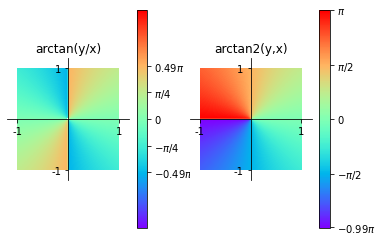

In [2]:
import matplotlib.pyplot as plt
import numpy as np

start, end, num = -1, 1, 1000
var = np.linspace(start, end, num + 1)  # 变量区间[-1,1]，在这之中取1001个数
x, y = np.meshgrid(var, var)
# x, y的shape都是(1001,1001)，表示这1001x1001个点的二维坐标


def plot(index, img, title, color_ticks, color_ticklabels):
    ax = plt.subplot(1, 2, index)
    ax.spines['right'].set_color('none')  # 调整坐标轴的位置
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('data', num / 2))
    ax.spines['left'].set_position(('data', num / 2))
    blank = num * 0.1
    ax.set_xlim(-blank, num + blank)
    ax.set_ylim(-blank, num + blank)  # 若不调整，y轴方向朝下
    ax.set_xticks([0, num])  # 因为有1001个点，所以取值范围是[0,1000]
    ax.set_xticklabels([start, end])  # 把取值还原回[-1,1]
    ax.set_yticks([0, num])
    ax.set_yticklabels([start, end])
    ax.set_title(title)
    ai = ax.imshow(img, cmap='rainbow', vmin=-1, vmax=1)
    colorbar = plt.colorbar(ai, ax=ax)
    colorbar.set_ticks(color_ticks)
    colorbar.set_ticklabels(color_ticklabels)


z = np.arctan(y / x) / np.pi
plot(1, z, 'arctan(y/x)', [-0.49, -0.25, 0, 0.25, 0.49],
     [r'$-0.49\pi$', r'$-\pi/4$', '0', r'$\pi/4$', r'0.49$\pi$'])

z = np.arctan2(y, x) / np.pi
plot(2, z, 'arctan2(y,x)', [-0.99, -0.5, 0, 0.5, 1],
     [r'$-0.99\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])

plt.show()

> $arctan$的值域是$(-\frac{\pi}{2},\frac{\pi}{2})$，图像是中心对称的，这不符合经度的变化规律；  
> $arctan2$的值域是$(-\pi,\pi]，$如果将$-\pi$和$\pi$相连，就像东西经$180°$那样，$arctan2$函数就是连续的。

回到xyz2BLH 迭代公式。$B、N、H$的三个量互相纠缠，需要通过迭代法来求值。假设$H=0$
$$B_0 =arctan(\frac{z}{(1-e^2)p})$$ 
那么
$$N_k=\frac{a}{\sqrt{1-e^2sin^2B_{k-1}}}$$
$$H_k=\frac{p}{cosB_{k-1}}-N_k$$
$$B_k=arctan(\frac{z}{(1-\frac{e^2N_k}{N_k+H_k})p})$$

In [5]:
import numpy as np


def rad2degree(rad):
    return rad * 180 / np.pi


def xyz2BLH(x, y, z, rad=True):
    a = 6378137.0000
    b = 6356752.3141
    e2 = 1 - (b / a)**2
    p = np.sqrt(x**2+y**2)
    L = np.arctan2(y, x)

    def ite(z,p):
        def cal_N(B): return a/np.sqrt(1-e2*np.sin(B)**2)
        def cal_H(N, B): return p/np.cos(B)-N
        def cal_B(N, H): return np.arctan(z/((1 - e2*N/(N+H))*p))
        B = cal_B(1, 0)
        N = cal_N(B)
        H0, H = 1e9, cal_H(N, B)
        while np.abs(H - H0) > 0.1:
            B = cal_B(N, H)
            N = cal_N(B)
            H0, H = H, cal_H(N, B)
        return H, B
    
    H, B = np.vectorize(ite)(z,p)
    if rad:
        return L, B * 1, H * 1  # 防止结果变成array(B),array(H)
    else:
        return rad2degree(L), rad2degree(B), H * 1


x, y, z = -2144900.7573362007, 4397698.262572753, 4078136.627140711
print(xyz2BLH(x, y, z, rad=False))

(116.0, 40.00000000005382, 235.00000501424074)


> # xyz2BLH 近似公式
> 已知$p=\sqrt{x^2+y^2}$，$L=arctan2(y,x)$，迭代公式中$B=arctan(\frac{z}{(1-\frac{e^2N}{N+H})p})$。放弃这个公式，设
> $$\theta=arctan(\frac{z\cdot a}{p\cdot b})$$
> $$e_2^2=(\frac{a}{b})^2-1=\frac{e^2}{1-e^2}$$
> 用
> $$B=arctan(\frac{z+e_2^2bsin^3\theta}{p-e^2acos^3\theta})$$
> 来替代迭代公式中的$B$表达式~~我也不知道原理是什么~~，$N$和$H$保持不变
> $$N=\frac{a}{\sqrt{1-e^2sin^2B}}$$ 
> $$H=\frac{p}{cosB}-N$$  

In [6]:
import numpy as np


def rad2degree(rad):
    return rad * 180 / np.pi


def xyz2BLH(x, y, z, rad=True):
    a = 6378137.0000
    b = 6356752.3141
    e2 = 1 - (b / a)**2
    p = np.sqrt(x**2+y**2)
    theta = np.arctan(z * a/(p * b))
    L = np.arctan2(y, x)
    B = np.arctan((z + e2/(1-e2)*b*np.sin(theta)**3)/(p - e2*a*np.cos(theta)**3))
    N = a/np.sqrt(1-e2*np.sin(B)**2)
    H = p / np.cos(B) - N
    if rad:
        return L, B, H
    else:
        return rad2degree(L), rad2degree(B), H


x, y, z = -2144900.7573362007, 4397698.262572753, 4078136.627140711
print(xyz2BLH(x, y, z, rad=False))
# 完全一致

(116.0, 40.00000000000001, 235.0)


最后探究一下这个近似公式的误差会如何变化：

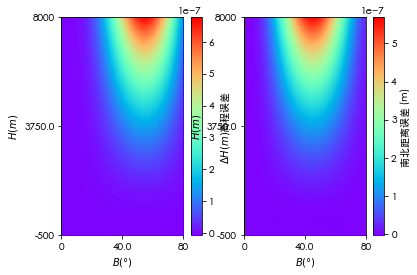

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签, windows
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # 用来正常显示中文标签, mac


def degree2rad(degree):
    return degree * np.pi / 180


def rad2degree(rad):
    return rad * 180 / np.pi


def BLH2xyz(L, B, H, rad=True):
    if not rad:
        L = degree2rad(L)
        B = degree2rad(B)
    a = 6378137.0000
    b = 6356752.3141
    e2 = 1 - (b / a)**2
    N = a/np.sqrt(1-e2*np.sin(B)**2)
    x = (N + H) * np.cos(B) * np.cos(L)
    y = (N + H) * np.cos(B) * np.sin(L)
    z = (N * (1 - e2) + H) * np.sin(B)
    return x, y, z


def xyz2BLH(x, y, z, rad=True):
    a = 6378137.0000
    b = 6356752.3141
    e2 = 1 - (b / a)**2
    p = np.sqrt(x**2+y**2)
    theta = np.arctan(z * a/(p * b))
    L = np.arctan2(y, x)
    B = np.arctan((z + e2/(1-e2)*b*np.sin(theta)**3) /
                  (p - e2*a*np.cos(theta)**3))
    N = a/np.sqrt(1-e2*np.sin(B)**2)
    H = p / np.cos(B) - N
    if rad:
        return L, B, H
    else:
        return rad2degree(L), rad2degree(B), H


def dB2distance(dB, rad=True):
    if not rad:
        dB = degree2rad(dB)
    a = 6378137.0000
    b = 6356752.3141
    r = (a + b) / 2  # 近似
    return r*dB


if __name__ == '__main__':
    L = 116
    Bmin, Bmax, Bnum = 0, 80, 240
    Hmin, Hmax, Hnum = -500, 8000, 850
    B = np.linspace(Bmin, Bmax, Bnum + 1)
    H = np.linspace(Hmin, Hmax, Hnum + 1)
    B, H = np.meshgrid(B, H)
    x, y, z = BLH2xyz(L, B, H, rad=False)
    l, b, h = xyz2BLH(x, y, z, rad=False)

    def plot(index, img, title):
        ax = plt.subplot(1, 2, index)
        ai = ax.imshow(img, aspect='auto', cmap='rainbow')
        ax.set_xlim(0, Bnum)
        ax.set_xticks([0, Bnum/2, Bnum])
        ax.set_xticklabels([Bmin, np.mean([Bmin, Bmax]), Bmax])
        ax.set_xlabel(r'$B (\degree)$')
        ax.set_ylim(0, Hnum)
        ax.set_yticks([0, Hnum/2, Hnum])
        ax.set_yticklabels([Hmin, (Hmin+Hmax)/2, Hmax])
        ax.set_ylabel(r'$H (m)$')
        plt.colorbar(ai, ax=ax).set_label(title)

    plot(1, h-H, r'$\Delta H (m)$高程误差')
    plot(2, dB2distance(b-B, rad=False), r'南北距离误差 (m)')
    plt.show()

误差不足微米，是非常理想的公式。